In [1]:
import sys, pickle, time, importlib
from pprint import pprint
import numpy as np
np.random.seed(42)
np.set_printoptions(threshold=sys.maxsize)
import scipy as spy
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

In [2]:
# Doc for loading IBMQ account https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq#the-account
# from qiskit import IBMQ
# IBMQ.save_account(TOKEN)
# IBMQ.load_account() # Load account from disk
# provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

# Real backend; needed for transpilation later on
#guadalupe = provider.get_backend("ibmq_guadalupe")

# Get fake backend if you like
from qiskit.providers.fake_provider import FakeGuadalupe

#Noisy simulator backend
noisy_sim = FakeGuadalupe()
from qiskit.opflow import Zero, One, I, X, Y, Z, PauliSumOp
from qiskit import Aer
from qiskit.providers.aer import QasmSimulator
#from qiskit.tools.monitor import job_monitor
#from qiskit.circuit import Parameter
backend = Aer.get_backend('qasm_simulator')

In [3]:
# Kagome unit cell
num_qubits = 16
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
import rustworkx as rx
graph_16 = rx.PyGraph(multigraph=False)
graph_16.add_nodes_from(range(num_qubits))
edge_list = [
    (1, 2, t),
    (2, 3, t),
    (3, 5, t),
    (5, 8, t),
    (8, 11, t),
    (11, 14, t),
    (14, 13, t),
    (13, 12, t),
    (12, 10, t),
    (10, 7, t),
    (7, 4, t),
    (4, 1, t),
    (4, 2, t),
    (2, 5, t),
    (5, 11, t),
    (11, 13, t),
    (13, 10, t),
    (10, 4, t),
]
# Generate graph from the list of edges
graph_16.add_edges_from(edge_list)

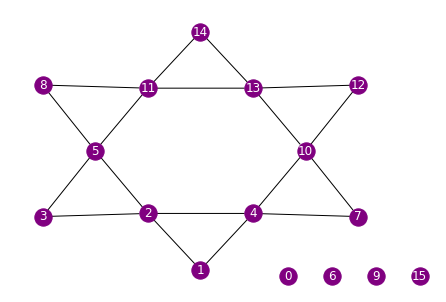

In [5]:
from qiskit_nature.problems.second_quantization.lattice import Lattice
# Make a Lattice from graph
kagome_unit_cell_16 = Lattice(graph_16)

# Draw Lattice and include labels to check we exclude the right spins
# Specify node locations for better visualizations
kagome_pos = {0:[1,-1], 6:[1.5,-1], 9:[2,-1], 15:[2.5,-1], 
              1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
              13:[0.6,5], 11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
              8:[-1.8,5.1], 14:[0,6.8], 7:[1.8,0.9], 12:[1.8,5.1]}
kagome_unit_cell_16.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':kagome_pos})
plt.show()

In [6]:
# Custom Heisenberg couplings
sys.path.append(r'.')  # may be needed if running notebook on a cloud service
from heisenberg_model import HeisenbergModel

# Build Hamiltonian from graph edges
heis_16 = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell_16,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)
heis_16

In [7]:
from qiskit_nature.mappers.second_quantization import LogarithmicMapper
# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_16 = 4 * log_mapper.map(heis_16.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 18 ZZ, 18 YY, and 18 XX terms over 16 qubits instead of over 12 qubits
ham_16

PauliSumOp(SparsePauliOp(['IZZIIIIIIIIIIIII', 'IIZZIIIIIIIIIIII', 'IZIIZIIIIIIIIIII', 'IIZIZIIIIIIIIIII', 'IIZIIZIIIIIIIIII', 'IIIZIZIIIIIIIIII', 'IIIIZIIZIIIIIIII', 'IIIIIZIIZIIIIIII', 'IIIIZIIIIIZIIIII', 'IIIIIIIZIIZIIIII', 'IIIIIZIIIIIZIIII', 'IIIIIIIIZIIZIIII', 'IIIIIIIIIIZIZIII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIIIZIZII', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIZZI', 'IYYIIIIIIIIIIIII', 'IIYYIIIIIIIIIIII', 'IYIIYIIIIIIIIIII', 'IIYIYIIIIIIIIIII', 'IIYIIYIIIIIIIIII', 'IIIYIYIIIIIIIIII', 'IIIIYIIYIIIIIIII', 'IIIIIYIIYIIIIIII', 'IIIIYIIIIIYIIIII', 'IIIIIIIYIIYIIIII', 'IIIIIYIIIIIYIIII', 'IIIIIIIIYIIYIIII', 'IIIIIIIIIIYIYIII', 'IIIIIIIIIIYIIYII', 'IIIIIIIIIIIYIYII', 'IIIIIIIIIIIIYYII', 'IIIIIIIIIIIYIIYI', 'IIIIIIIIIIIIIYYI', 'IXXIIIIIIIIIIIII', 'IIXXIIIIIIIIIIII', 'IXIIXIIIIIIIIIII', 'IIXIXIIIIIIIIIII', 'IIXIIXIIIIIIIIII', 'IIIXIXIIIIIIIIII', 'IIIIXIIXIIIIIIII', 'IIIIIXIIXIIIIIII', 'IIIIXIIIIIXIIIII', 'IIIIIIIXIIXIIIII', 'IIIIIXIIIIIXIIII', 'IIIIIIIIXIIXIIII', 'IIIIIIIIIIXIX

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

num_layers = 2

# Build a custom ansatz from scratch
ansatz_custom = QuantumCircuit(12)
# build initial state
# ansatz_custom.h(range(0, 12, 2))

iter_layer = 0

ansatz_custom.x(range(1,12,2))

ansatz_custom.cx(range(0, 12, 2), range(1, 12, 2))
ansatz_custom.cz(range(1, 12, 2), range(0, 11, 2))

for i in range(6):
    theta=Parameter('θ_' + str(iter_layer))
    ansatz_custom.ry(theta, 2 * i)
    ansatz_custom.cz(2 * i, 2 * i + 1)
    ansatz_custom.ry(-1.0 * theta, 2 * i)
    iter_layer += 1

ansatz_custom.cx(range(0, 11, 2), range(1, 12, 2))
ansatz_custom.cx(range(1, 11, 2), range(2, 12, 2))
for i in range(5):
    theta=Parameter('θ_' + str(iter_layer))
    ansatz_custom.cz(2 * i + 2, 2 * i + 1)
    ansatz_custom.ry(theta, 2 * i + 1)
    ansatz_custom.cz(2 * i + 2, 2 * i + 1)
    ansatz_custom.ry(-1.0 * theta, 2 * i + 1)
    iter_layer += 1
    
ansatz_custom.cx(range(1, 11, 2), range(2, 12, 2))
ansatz_custom.draw("mpl", fold=250)

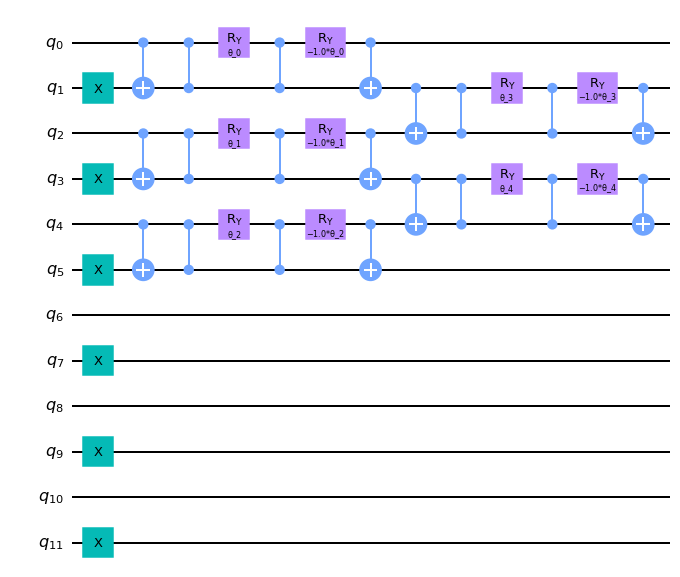

In [9]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

num_layers = 2

# Build a custom ansatz from scratch
ansatz_custom = QuantumCircuit(12)

ansatz_custom.x(range(1,12,2))
ansatz_custom.cx(range(0, 6, 2), range(1, 6, 2))
ansatz_custom.cz(range(1, 6, 2), range(0, 6, 2))

j = 0
for i in range(3):
    theta=Parameter('θ_' + str(j))
    ansatz_custom.ry(theta, 2*i)
    ansatz_custom.cz(2*i, 2*i+1)
    ansatz_custom.ry(-1.0*theta, 2*i)
    j += 1

ansatz_custom.cx(range(0, 6, 2), range(1, 6, 2))

ansatz_custom.cx(range(1, 5, 2), range(2, 6, 2))
for i in range(2):
    theta=Parameter('θ_' + str(j))
    ansatz_custom.cz(2*i+2, 2*i+1)
    ansatz_custom.ry(theta, 2*i+1)
    ansatz_custom.cz(2*i+2, 2*i+1)
    ansatz_custom.ry(-1.0*theta, 2*i+1)
    j += 1
ansatz_custom.cx(range(1, 5, 2), range(2, 6, 2))
ansatz_custom.draw(output="mpl", fold=250)

number and type of gates in the cirucit: OrderedDict([('rz', 56), ('sx', 31), ('cx', 20), ('x', 6)])
number of parameters in the circuit: 5


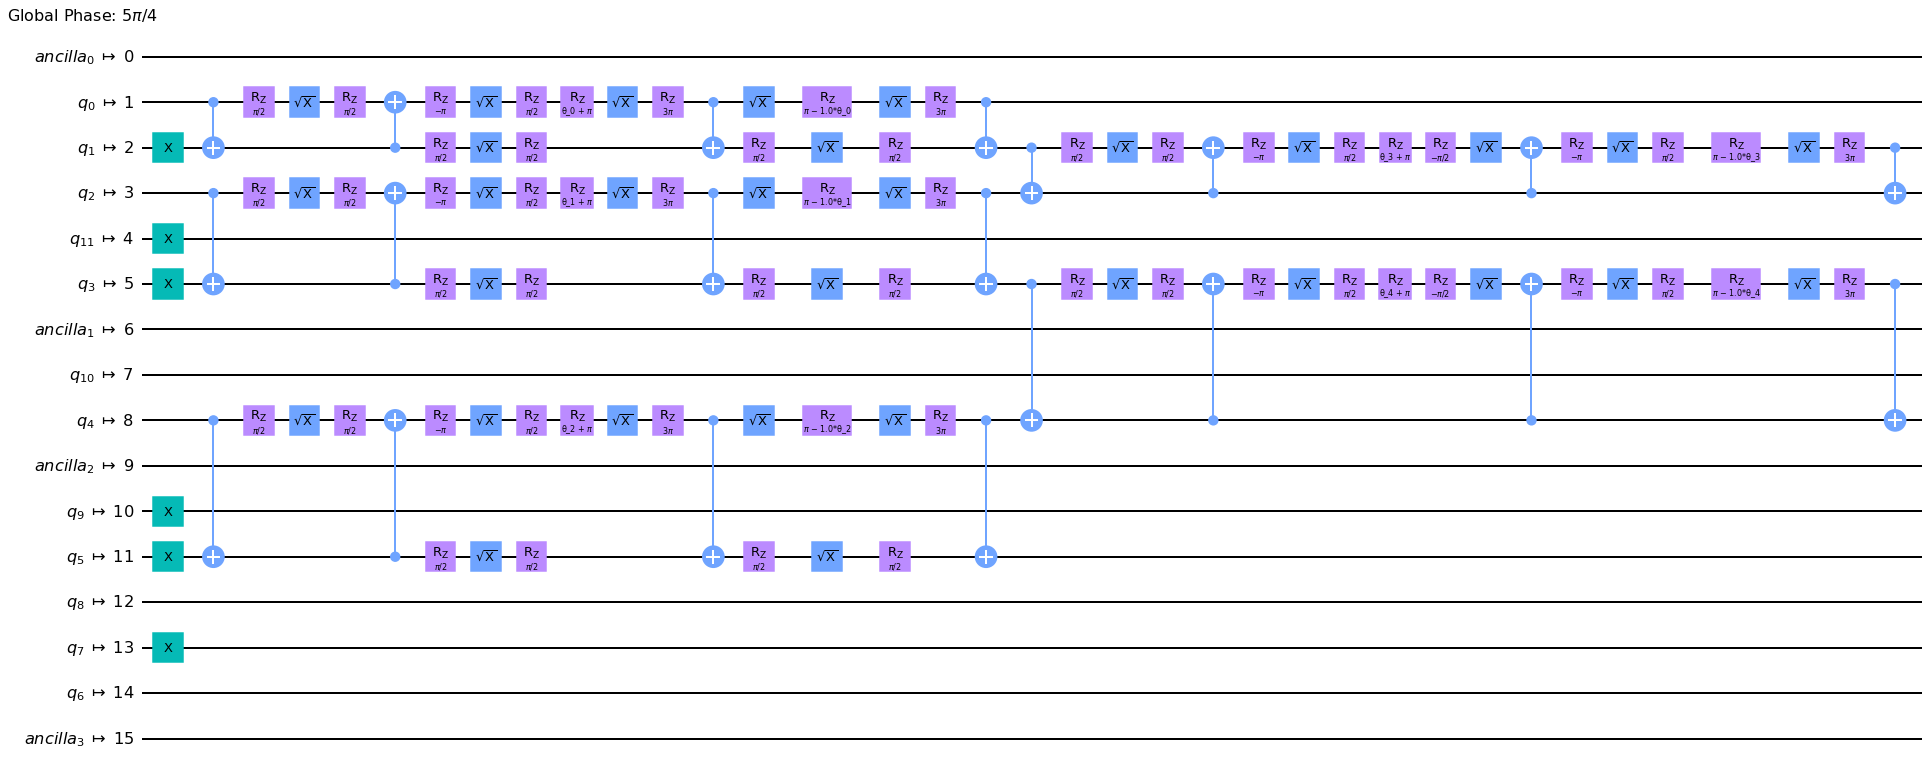

In [11]:
# Force anstaz to be applied to qubits in the heavy hex.
# Avoid the outer qubits 0, 6, 9, and 15 which we accounted for in the lattice definition.
from qiskit import transpile
q_layout = [1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4]
ansatz_opt = transpile(ansatz_custom, backend=noisy_sim, initial_layout=q_layout)

print('number and type of gates in the cirucit:', ansatz_opt.count_ops())
print('number of parameters in the circuit:', ansatz_opt.num_parameters)
ansatz_opt.draw(output="mpl", fold=400)

In [12]:
from qiskit.algorithms.optimizers import SPSA, AQGD, GradientDescent, ADAM, QNSPSA

optimizer = GradientDescent(maxiter=50, learning_rate=0.2)
#optimizer = SPSA(maxiter=100, second_order=True)

In [13]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        """
        initialise attributes
        """
        self._estimator = estimator ### memo: 
        self._circuit = circuit ### memo: the quantum circuit
        self._optimizer = optimizer ### memo: optimizer
        self._callback = callback ### memo: call back function
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        # x0 =np.pi/4*0.0
        
        ### Run optimization ###
        ### MAIN PROCESS ###
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [14]:
# Define a simple callback function
intermediate_info = []
def callback(value):
    intermediate_info.append(value)
    print(value)

In [15]:
from qiskit.primitives import Estimator

In [21]:
from qiskit.opflow import PauliSumOp

In [22]:
from qiskit.quantum_info import SparsePauliOp

In [ ]:
from utils import *
from heisenberg_model import HeisenbergModel

In [27]:
pauli_str_list = {'ZZIIII', 'IZZIII', 'IZIZII', 'IIZZII', 'IIIZZI', 'IIIZIZ', 
                  'IIIIZZ', 'YYIIII', 'IYYIII', 'IYIYII', 'IIYYII', 'IIIYYI', 
                  'IIIYIY', 'IIIIYY', 'XXIIII', 'IXXIII', 'IXIXII', 'IIXXII', 
                  'IIIXXI', 'IIIXIX', 'IIIIXX'}
coeff_list = [1.0] * len(pauli_str_list)
H = SparsePauliOp(pauli_str_list, coeff_list)
print(H)

SparsePauliOp(['IIIYIY', 'IYYIII', 'YYIIII', 'IZZIII', 'ZZIIII', 'IZIZII', 'XXIIII', 'IIXXII', 'IIIYYI', 'IIIXIX', 'IIIZZI', 'IIIXXI', 'IXXIII', 'IIIZIZ', 'IIIIZZ', 'IIZZII', 'IYIYII', 'IIYYII', 'IXIXII', 'IIIIXX', 'IIIIYY'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j])


In [ ]:
# for {II, IZ, ZI, ZZ}
for i in range(2):
    pauli_str_list = ["I" * (2 * i + 1) + "II" + "I"*(3 - 2 * i),
                      "I" * (2 * i + 1) + "XI" + "I"*(3 - 2 * i),
                      "I" * (2 * i + 1) + "IZ" + "I"*(3 - 2 * i),
                      "I" * (2 * i + 1) + "XZ" + "I"*(3 - 2 * i)]
    A = SparsePauliOp(pauli_str_list, [0.5, 0.5, 0.5, -0.5])
    H = A * H * A

In [ ]:
for i in range(2):
    if 0.25 * np.pi < result.optimal_parameters[4 - i] % (2 * np.pi) < 0.75 * np.pi:
        A = SparsePauliOp(["I"*6, "I"*(3-2*i)+"Y"+"I"*(2*i+2)], [np.sqrt(0.5), 1j * np.sqrt(0.5)]) ### changed 12 to 6
        B = SparsePauliOp(["I"*6, "I"*(3-2*i)+"Y"+"I"*(2*i+2)], [np.sqrt(0.5), -1j * np.sqrt(0.5)]) ### changed 12 to 6
        H = B * H * A
    elif 0.75 * np.pi < result.optimal_parameters[4 - i] % (2 * np.pi) < 1.25 * np.pi:
        A = SparsePauliOp(["I"*(9-2*i)+"Y"+"I"*(2*i+2)], [1.0]) ### why 9? ###
        H = A * H * A
    elif 1.25 * np.pi < result.optimal_parameters[4 - i] % (2 * np.pi) < 1.75 * np.pi:
        A = SparsePauliOp(["I"*6, "I"*(3-2*i)+"Y"+"I"*(2*i+2)], [np.sqrt(0.5), 1j * np.sqrt(0.5)]) ### changed 12 to 6
        B = SparsePauliOp(["I"*6, "I"*(3-2*i)+"Y"+"I"*(2*i+2)], [np.sqrt(0.5), -1j * np.sqrt(0.5)]) ### changed 12 to 6
        H = A * H * B
    else:
        continue

In [30]:
# for {II, IZ, ZI, ZZ}
for i in range(2):
    pauli_str_list = SparsePauliOp(["I"*(2*i+1)+"II"+"I"*(3-2*i),
                                    "I"*(2*i+1)+"IZ"+"I"*(3-2*i),
                                    "I"*(2*i+1)+"ZI"+"I"*(3-2*i),
                                    "I"*(2*i+1)+"ZZ"+"I"*(3-2*i)])
    A = SparsePauliOp(pauli_str_list, [0.5, 0.5, 0.5, -0.5])
    H = A * H * A

SyntaxError: invalid syntax (3606854886.py, line 3)

In [ ]:
for i in range(2):
    if 0.25 * np.pi < result.optimal_parameters[4 - i] % (2 * np.pi) < 0.75 * np.pi:
        A = SparsePauliOp(["I"*6, "I"*(3-2*i)+"Y"+"I"*(2*i+2)], [np.sqrt(0.5), 1j * np.sqrt(0.5)]) ### changed 12 to 6
        B = SparsePauliOp(["I"*6, "I"*(3-2*i)+"Y"+"I"*(2*i+2)], [np.sqrt(0.5), -1j * np.sqrt(0.5)]) ### changed 12 to 6
        H = B * H * A
    elif 0.75 * np.pi < result.optimal_parameters[4 - i] % (2 * np.pi) < 1.25 * np.pi:
        A = SparsePauliOp(["I"*(9-2*i)+"Y"+"I"*(2*i+2)], [1.0]) ### why 9? ###
        H = A * H * A
    elif 1.25 * np.pi < result.optimal_parameters[4 - i] % (2 * np.pi) < 1.75 * np.pi:
        A = SparsePauliOp(["I"*6, "I"*(3-2*i)+"Y"+"I"*(2*i+2)], [np.sqrt(0.5), 1j * np.sqrt(0.5)]) ### changed 12 to 6
        B = SparsePauliOp(["I"*6, "I"*(3-2*i)+"Y"+"I"*(2*i+2)], [np.sqrt(0.5), -1j * np.sqrt(0.5)]) ### changed 12 to 6
        H = A * H * B
    else:
        continue

In [197]:
for i in range(2):
    if 0.25*np.pi < result.optimal_parameters[4-i]% (2*np.pi) < 0.75*np.pi:
        A=Hamiltonian({"I"*12:np.sqrt(0.5),"I"*(3-2*i)+"Y"+"I"*(2*i+2):1j*np.sqrt(0.5)})
        B=Hamiltonian({"I"*12:np.sqrt(0.5),"I"*(3-2*i)+"Y"+"I"*(2*i+2):-1j*np.sqrt(0.5)})
        H=A*H*B
    elif 0.75*np.pi < result.optimal_parameters[4-i]% (2*np.pi) < 1.25*np.pi:
        A=Hamiltonian({"I"*(3-2*i)+"Y"+"I"*(2*i+2):1.0})
        H=A*H*A
    elif 1.25*np.pi < result.optimal_parameters[4-i]% (2*np.pi) < 1.75*np.pi:
        A=Hamiltonian({"I"*12:np.sqrt(0.5),"I"*(3-2*i)+"Y"+"I"*(2*i+2):1j*np.sqrt(0.5)})
        B=Hamiltonian({"I"*12:np.sqrt(0.5),"I"*(3-2*i)+"Y"+"I"*(2*i+2):-1j*np.sqrt(0.5)})
        H=B*H*A
    else:
        H=H
        
for i in range(2):
    A=Hamiltonian({"I"*(2*i+1)+"II"+"I"*(3-2*i):0.5,"I"*(2*i+1)+"IZ"+"I"*(3-2*i):0.5,"I"*(2*i+1)+"ZI"+"I"*(3-2*i):0.5,"I"*(2*i+1)+"ZZ"+"I"*(3-2*i):-0.5})
    print(A)
    H=A*H*A
        
for i in range(2):
    A=Hamiltonian({"I"*(2*i+1)+"II"+"I"*(3-2*i):0.5,"I"*(2*i+1)+"XI"+"I"*(3-2*i):0.5,"I"*(2*i+1)+"IZ"+"I"*(3-2*i):0.5,"I"*(2*i+1)+"XZ"+"I"*(3-2*i):-0.5})
    print(A)
    H=A*H*A
    
#operate cz
for i in range(3):
    A=Hamiltonian({"I"*(2*i)+"II"+"I"*(4-2*i):0.5,"I"*(2*i)+"IZ"+"I"*(4-2*i):0.5,"I"*(2*i)+"XI"+"I"*(4-2*i):0.5,"I"*(2*i)+"XZ"+"I"*(4-2*i):-0.5})
    print(A)
    H=A*H*A
    

for i in range(3):
    if 0.25*np.pi < result.optimal_parameters[2-i]% (2*np.pi) < 0.75*np.pi:
        A=Hamiltonian({"I"*12:np.sqrt(0.5),"I"*(4-2*i)+"Y"+"I"*(2*i+1):1j*np.sqrt(0.5)})
        B=Hamiltonian({"I"*12:np.sqrt(0.5),"I"*(4-2*i)+"Y"+"I"*(2*i+1):-1j*np.sqrt(0.5)})
        H=B*H*A
    elif 0.75*np.pi < result.optimal_parameters[2-i]% (2*np.pi) < 1.25*np.pi:
        A=Hamiltonian({"I"*(4-2*i)+"Y"+"I"*(2*i+1):1.0})
        H=A*H*A
    elif 1.25*np.pi < result.optimal_parameters[2-i]% (2*np.pi) < 1.75*np.pi:
        A=Hamiltonian({"I"*12:np.sqrt(0.5),"I"*(4-2*i)+"Y"+"I"*(2*i+1):1j*np.sqrt(0.5)})
        B=Hamiltonian({"I"*12:np.sqrt(0.5),"I"*(4-2*i)+"Y"+"I"*(2*i+1):-1j*np.sqrt(0.5)})
        H=A*H*B
    else:
        H=H

for i in range(3):
    A=Hamiltonian({"I"*(2*i)+"II"+"I"*(4-2*i):0.5,"I"*(2*i)+"IZ"+"I"*(4-2*i):0.5,"I"*(2*i)+"ZI"+"I"*(4-2*i):0.5,"I"*(2*i)+"ZZ"+"I"*(4-2*i):-0.5})
    print(A)
    H=A*H*A
        
for i in range(3):
    if 0.25*np.pi < result.optimal_parameters[2-i]% (2*np.pi) < 0.75*np.pi:
        A=Hamiltonian({"I"*12:np.sqrt(0.5),"I"*(4-2*i)+"Y"+"I"*(2*i+1):1j*np.sqrt(0.5)})
        B=Hamiltonian({"I"*12:np.sqrt(0.5),"I"*(4-2*i)+"Y"+"I"*(2*i+1):-1j*np.sqrt(0.5)})
        H=A*H*B
    elif 0.75*np.pi < result.optimal_parameters[2-i]% (2*np.pi) < 1.25*np.pi:
        A=Hamiltonian({"I"*(4-2*i)+"Y"+"I"*(2*i+1):1.0})
        H=A*H*A
    elif 1.25*np.pi < result.optimal_parameters[2-i]% (2*np.pi) < 1.75*np.pi:
        A=Hamiltonian({"I"*12:np.sqrt(0.5),"I"*(4-2*i)+"Y"+"I"*(2*i+1):1j*np.sqrt(0.5)})
        B=Hamiltonian({"I"*12:np.sqrt(0.5),"I"*(4-2*i)+"Y"+"I"*(2*i+1):-1j*np.sqrt(0.5)})
        H=B*H*A
    else:
        H=H
        
for i in range(3):
    A=Hamiltonian({"I"*(2*i)+"II"+"I"*(4-2*i):0.5,
                   "I"*(2*i)+"IZ"+"I"*(4-2*i):0.5,
                   "I"*(2*i)+"ZI"+"I"*(4-2*i):0.5,
                   "I"*(2*i)+"ZZ"+"I"*(4-2*i):-0.5})
    print(A)
    H=A*H*A
        
for i in range(3):
    A=Hamiltonian({"I"*(2*i)+"II"+"I"*(4-2*i):0.5,
                   "I"*(2*i)+"IZ"+"I"*(4-2*i):0.5,
                   "I"*(2*i)+"XI"+"I"*(4-2*i):0.5,
                   "I"*(2*i)+"XZ"+"I"*(4-2*i):-0.5})
    print(A)
    H=A*H*A
        
        
print(H)

{'IIIIII': 0.5, 'IXIIII': 0.5, 'IIZIII': 0.5, 'IXZIII': -0.5}
{'IIIIII': 0.5, 'IIIXII': 0.5, 'IIIIZI': 0.5, 'IIIXZI': -0.5}
{'IIIIII': 0.5, 'IIZIII': 0.5, 'IZIIII': 0.5, 'IZZIII': -0.5}
{'IIIIII': 0.5, 'IIIIZI': 0.5, 'IIIZII': 0.5, 'IIIZZI': -0.5}
{'IIIIII': 0.5, 'IIZIII': 0.5, 'IZIIII': 0.5, 'IZZIII': -0.5}
{'IIIIII': 0.5, 'IIIIZI': 0.5, 'IIIZII': 0.5, 'IIIZZI': -0.5}
{'IIIIII': 0.5, 'IXIIII': 0.5, 'IIZIII': 0.5, 'IXZIII': -0.5}
{'IIIIII': 0.5, 'IIIXII': 0.5, 'IIIIZI': 0.5, 'IIIXZI': -0.5}
{'IIIIII': 0.5, 'IZIIII': 0.5, 'XIIIII': 0.5, 'XZIIII': -0.5}
{'IIIIII': 0.5, 'IIIZII': 0.5, 'IIXIII': 0.5, 'IIXZII': -0.5}
{'IIIIII': 0.5, 'IIIIIZ': 0.5, 'IIIIXI': 0.5, 'IIIIXZ': -0.5}
{'IIIIII': 0.5, 'IZIIII': 0.5, 'ZIIIII': 0.5, 'ZZIIII': -0.5}
{'IIIIII': 0.5, 'IIIZII': 0.5, 'IIZIII': 0.5, 'IIZZII': -0.5}
{'IIIIII': 0.5, 'IIIIIZ': 0.5, 'IIIIZI': 0.5, 'IIIIZZ': -0.5}
{'IIIIII': 0.5, 'IZIIII': 0.5, 'ZIIIII': 0.5, 'ZZIIII': -0.5}
{'IIIIII': 0.5, 'IIIZII': 0.5, 'IIZIII': 0.5, 'IIZZII': -0.5}
{'IIIIII

In [217]:
#apply for the 16 qubits device 


Heff=Hamiltonian({"I"*16:0.0})
for operator, coeff in H.items():
    operator=operator+"I"*10
    operator_dum=Hamiltonian({"I"*16:1.0})
    j=0
    for i in q_layout:
        operator_dum=operator_dum*Hamiltonian({"I"*(15-i)+operator[j]+"I"*(i):1.0})
        j+=1
    Heff=Heff+operator_dum*Hamiltonian({"I"*16:round(coeff)})

print(Heff)

n=0
Heff_operator=""

Heff_coeff= np.zeros((22))

for operator, coeff in Heff.items():
    Heff_operator= Heff_operator + operator if Heff_operator == "" else Heff_operator+" "+operator 
    Heff_coeff[n]=coeff
    print("operator=",operator)
    print("coeff[",n,"]",Heff_coeff[n])
    n+=1

Heff_operator2 = Heff_operator.split()
    
import logging
import numpy as np
from fractions import Fraction
from typing import Optional

from qiskit_nature.second_q.operators import SpinOp
from qiskit_nature.problems.second_quantization.lattice.lattices import Lattice
from qiskit_nature.problems.second_quantization.lattice.models.lattice_model import LatticeModel

from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp

#SparsePauliOp(Heff_operator2,np.array(Heff_coeff))
ham_eff=PauliSumOp(SparsePauliOp(Heff_operator2,np.array(Heff_coeff)))

#ham_eff=SpinOp({"X_0":0.0},spin=Fraction(1,2), num_spins=16)
#for operator, coeff in Heff.items():
#    operator_dum2=""
##    for i in range(len(operator)):
 #       if operator[i]=="I":
#            continue
#        else:
#            operator_dum2 += operator[i] + "_" + str(i) if operator_dum2 == "" else " " + operator[i] + "_" + str(i)
#    ham_eff = ham_eff + SpinOp({operator_dum2: coeff}, num_spins=16)

print(ham_eff)
print("upforward is ham_eff")


{'IIIIIIIIIIIIIIII': 0.0, 'IIIIIIIIIIIIIZZI': 1.0, 'IIIIIIIIIIIIZZII': 1.0, 'IIIIIIIIIIZIIZII': 1.0, 'IIIIIIIIIIZIZIII': 1.0, 'IIIIIIIZIIZIIIII': 1.0, 'IIIIZIIIIIZIIIII': 1.0, 'IIIIZIIZIIIIIIII': 1.0, 'IIIIIIIIIIIIIYYI': 1.0, 'IIIIIIIIIIIIYYII': 1.0, 'IIIIIIIIIIYIIYII': 1.0, 'IIIIIIIIIIYIYIII': 1.0, 'IIIIIIIYIIYIIIII': 1.0, 'IIIIYIIIIIYIIIII': 1.0, 'IIIIYIIYIIIIIIII': 1.0, 'IIIIIIIIIIIIIXXI': 1.0, 'IIIIIIIIIIIIXXII': 1.0, 'IIIIIIIIIIXIIXII': 1.0, 'IIIIIIIIIIXIXIII': 1.0, 'IIIIIIIXIIXIIIII': 1.0, 'IIIIXIIIIIXIIIII': 1.0, 'IIIIXIIXIIIIIIII': 1.0}
operator= IIIIIIIIIIIIIIII
coeff[ 0 ] 0.0
operator= IIIIIIIIIIIIIZZI
coeff[ 1 ] 1.0
operator= IIIIIIIIIIIIZZII
coeff[ 2 ] 1.0
operator= IIIIIIIIIIZIIZII
coeff[ 3 ] 1.0
operator= IIIIIIIIIIZIZIII
coeff[ 4 ] 1.0
operator= IIIIIIIZIIZIIIII
coeff[ 5 ] 1.0
operator= IIIIZIIIIIZIIIII
coeff[ 6 ] 1.0
operator= IIIIZIIZIIIIIIII
coeff[ 7 ] 1.0
operator= IIIIIIIIIIIIIYYI
coeff[ 8 ] 1.0
operator= IIIIIIIIIIIIYYII
coeff[ 9 ] 1.0
operator= IIIIIIIIIIYIIYII
co

In [218]:
optimizer=GradientDescent(maxiter=400, learning_rate=0.1, tol=10e-3)
# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator([ansatz_opt], [ham_eff])

# Setup VQE algorithm
custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)
print("VQE Lunning...")
# Run the custom VQE function and monitor execution time
result = custom_vqe.compute_minimum_eigenvalue(ham_eff)

print(result)
print(H)

VQE Lunning...
-7.9089165969936985
-7.90806899952193
-7.931758968293096
-7.917595453674148
-7.8789785103180625
-7.896471023118265
-8.879705043902598
-8.880550759383494
-8.87702320273153
-8.876675392504833
-8.871673425934723
-8.877029030040635
-8.946442139408354
-8.94669388240554
-8.942845749795714
-8.944698576866807
-8.942217283131468
-8.944192144241658
-8.975619797160936
-8.975645416313526
-8.973237044107657
-8.974345597937312
-8.972535097022751
-8.974032158361897
-8.989285735581934
-8.989284828741873
-8.987584386807654
-8.988387676470145
-8.987113203365526
-8.988143832240103
-8.995568990686824
-8.995567191498965
-8.994362924281505
-8.994930162302486
-8.994023856600542
-8.994754095843604
-8.998327763171968
-8.998327120840298
-8.997469669563854
-8.997873373265021
-8.997228451991255
-8.997746690525148
-8.99942896067089
-8.999428837518899
-8.998818030094752
-8.999105504904485
-8.99864622229253
-8.999014920519402
-8.999776540252938
-8.999776541011315
-8.999341389870015
-8.999546212406303


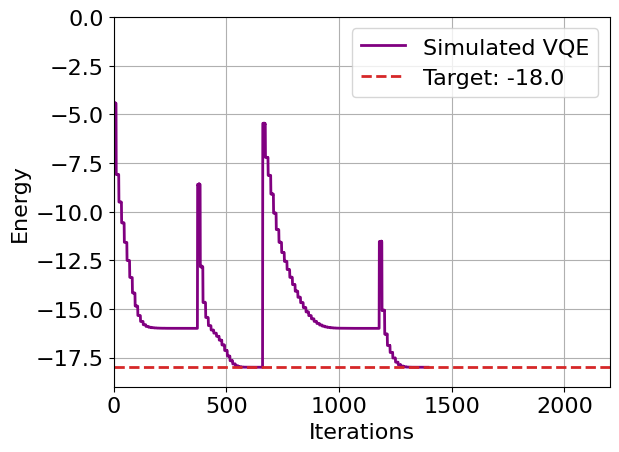

In [67]:
# Figureを設定
fig = plt.figure()

# グラフ描画領域を追加
ax = fig.add_subplot(111)

ax.set_ylim(-19.00,0.00)
ax.set_xlim(0,2200)

plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [142]:
def rel_err(target, measured):
    return abs((target - measured) / target)

# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

Expected ground state energy: -18.0000000000
Computed ground state energy: -17.9988409711
Relative error: 0.00006439


In [143]:
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)
from qiskit import Aer

# Save an IBM Quantum account. See docs for credential security warning
# https://github.com/Qiskit/qiskit-ibm-runtime/tree/stable/0.7#saving-account-on-disk
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="MY_IBM_QUANTUM_TOKEN")
service = QiskitRuntimeService(channel='ibm_quantum')

In [144]:
# print available backend and select one
print('Simulators:', service.backends(simulator=True))

# Select a simulator backend
backend = 'simulator_statevector'

Simulators: [<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_stabilizer')>]


In [145]:
# Define a simple callback function
intermediate_info_sim_backend = []
def callback_sim(value):
        intermediate_info_sim_backend.append(value)

In [146]:
import signal, time

from qiskit_ibm_runtime import Estimator, Session
from qiskit.providers import JobStatus

def timeout_handler(signum, frame):
    raise Exception('Iteration timed out')
    
class RetryEstimator(Estimator):
    """RuntimeRetryEstimator class.
    
    This class inherits from Qiskit IBM Runtime's Estimator and overwrites its run method such that it retries calling it
    a maximum of 'max_retries' consecutive times, if it encounters one of the following randomly occuring errors:
    
    * An Estimator error (in this case "Job.ERROR" is printed, and the job is cancelled automatically)
    * A timeout error where the job either remains running or completes but does not return anything, for a time larger 
      than 'timeout' (in this case the job is cancelled by the patch and "Job.CANCELLED" is printed)
    * A creation error, where the job fails to be created because connection is lost between the runtime server and the
      quantum computer (in this case "Failed to create job." is printed). If this error occurs, the patch connects the user
      to a new Session (to be handled with care! also, this will unfortunately put the next job in the queue). 
    """
    
    def __init__(self, *args, max_retries: int = 5, timeout: int = 3600, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.max_retries = max_retries
        self.timeout = timeout
        self.backend = super().session._backend
        signal.signal(signal.SIGALRM, timeout_handler)
    
    def run(self, circuits, observables, parameter_values, **kwargs):
        result = None
        for i in range(self.max_retries):
            try:
                job = super().run(circuits, observables, parameter_values, **kwargs)
                while job.status() in [JobStatus.INITIALIZING, JobStatus.QUEUED, JobStatus.VALIDATING]:
                    time.sleep(5) # Check every 5 seconds whether job status has changed
                signal.alarm(self.timeout) # Once job starts running, set timeout to 1 hour by default
                result = job.result()
                if result is not None:
                    signal.alarm(0) # reset timer
                    return job
            except Exception as e:
                print("\nSomething went wrong...")
                print(f"\n\nERROR MESSAGE:\n{e}\n\n")
                if 'job' in locals(): # Sometimes job fails to create
                    print(f"Job ID: {job.job_id}. Job status: {job.status()}.")
                    if job.status() not in [JobStatus.DONE, JobStatus.ERROR, JobStatus.CANCELLED]:
                        job.cancel()
                else:
                    print("Failed to create job.")
                print(f"Starting trial number {i+2}...\n")
                print(f"Creating new session...\n")
                signal.alarm(0) # reset timer
                super().session.close()
                self._session = Session(backend=self.backend)
        if result is None:
            raise RuntimeError(f"Program failed! Maximum number of retries ({self.max_retries}) exceeded")

In [147]:
# Setup Estimator with session error handling reconnection work around
start = time.time()
with Session(service=service, backend=backend) as session:
    # Prepare extended primitive
    rt_estimator = RetryEstimator(session=session)
    # set up algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_real)
    # run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time.time()
print(f'execution time (s): {end - start:.2f}')

Traceback (most recent call last):
  Cell In[147], line 7
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_real)
NameError: name 'callback_real' is not defined

Use %tb to get the full traceback.


In [130]:
# # Setup Estimator (standard method)
# start = time()
# with Session(service=service, backend=backend) as session:
#     # Prepare primitive
#     rt_estimator = RuntimeEstimator(session=session)
#     # Set up algorithm
#     custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_sim)
#     # Run algorithm
#     result = custom_vqe.compute_minimum_eigenvalue(ham_16)
# end = time()
# print(f'execution time (s): {end - start:.2f}')

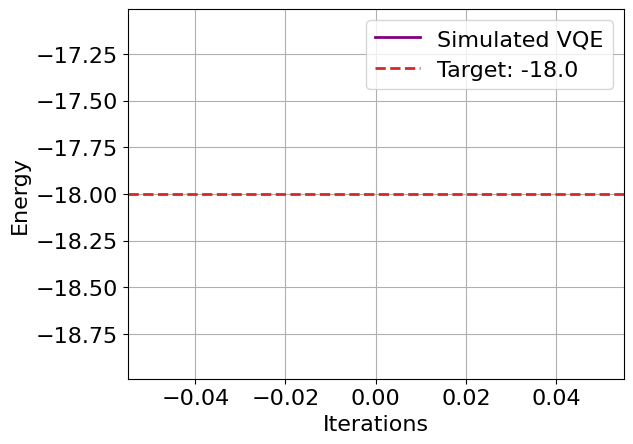

In [131]:
plt.plot(intermediate_info_sim_backend, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [74]:
# Compute the relative error between the expected ground state energy and the measured
rel_error = rel_err(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

Expected ground state energy: -18.0000000000
Computed ground state energy: -5.8767353505
Relative error: 0.67351470


In [ ]:
## 3-2 Qiskit runtime Real backend (ibmq_guadalupe)

If our `qiskit_ibm_runtime` code is working on the cloud simulator backend, we can simply change the backend to the ibmq_guadalupe to run on the real backend. This may take a couple hours. Your performance score will be determined by the calculated relative error between the true ground state energy of -18.0 and the measured energy from the real ibmq_guadalupe backend.

In [75]:
# service = QiskitRuntimeService(channel='ibm_quantum')
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-community/ibmquantumawards/open-science-22',
)

backend = 'ibmq_guadalupe'

/opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:448: UserWarning: Default hub/group/project ibm-q-community/ibmquantumawards/open-science-22 not found for the account and is ignored.
  warnings.warn(


In [76]:
# Define a simple callback function
intermediate_info_real_backend = []
def callback_real(value):
        intermediate_info_real_backend.append(value)

In [77]:
import signal, time

from qiskit_ibm_runtime import Estimator, Session
from qiskit.providers import JobStatus

def timeout_handler(signum, frame):
    raise Exception('Iteration timed out')
    
class RetryEstimator(Estimator):
    """RuntimeRetryEstimator class.
    
    This class inherits from Qiskit IBM Runtime's Estimator and overwrites its run method such that it retries calling it
    a maximum of 'max_retries' consecutive times, if it encounters one of the following randomly occuring errors:
    
    * An Estimator error (in this case "Job.ERROR" is printed, and the job is cancelled automatically)
    * A timeout error where the job either remains running or completes but does not return anything, for a time larger 
      than 'timeout' (in this case the job is cancelled by the patch and "Job.CANCELLED" is printed)
    * A creation error, where the job fails to be created because connection is lost between the runtime server and the
      quantum computer (in this case "Failed to create job." is printed). If this error occurs, the patch connects the user
      to a new Session (to be handled with care! also, this will unfortunately put the next job in the queue). 
    """
    
    def __init__(self, *args, max_retries: int = 5, timeout: int = 3600, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.max_retries = max_retries
        self.timeout = timeout
        self.backend = super().session._backend
        signal.signal(signal.SIGALRM, timeout_handler)
    
    def run(self, circuits, observables, parameter_values, **kwargs):
        result = None
        for i in range(self.max_retries):
            try:
                job = super().run(circuits, observables, parameter_values, **kwargs)
                while job.status() in [JobStatus.INITIALIZING, JobStatus.QUEUED, JobStatus.VALIDATING]:
                    time.sleep(5) # Check every 5 seconds whether job status has changed
                signal.alarm(self.timeout) # Once job starts running, set timeout to 1 hour by default
                result = job.result()
                if result is not None:
                    signal.alarm(0) # reset timer
                    return job
            except Exception as e:
                print("\nSomething went wrong...")
                print(f"\n\nERROR MESSAGE:\n{e}\n\n")
                if 'job' in locals(): # Sometimes job fails to create
                    print(f"Job ID: {job.job_id}. Job status: {job.status()}.")
                    if job.status() not in [JobStatus.DONE, JobStatus.ERROR, JobStatus.CANCELLED]:
                        job.cancel()
                else:
                    print("Failed to create job.")
                print(f"Starting trial number {i+2}...\n")
                print(f"Creating new session...\n")
                signal.alarm(0) # reset timer
                super().session.close()
                self._session = Session(backend=self.backend)
        if result is None:
            raise RuntimeError(f"Program failed! Maximum number of retries ({self.max_retries}) exceeded")

In [78]:
# Setup Estimator with session error handling reconnection work around
start = time.time()
with Session(service=service, backend=backend) as session:
    # Prepare extended primitive
    rt_estimator = RetryEstimator(session=session)
    # set up algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_real)
    # run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time.time()
print(f'execution time (s): {end - start:.2f}')


Something went wrong...


ERROR MESSAGE:
'Backend ibmq_guadalupe cannot be found in any hub/group/project for this account.'


Failed to create job.
Starting trial number 2...

Creating new session...


Something went wrong...


ERROR MESSAGE:
'Backend ibmq_guadalupe cannot be found in any hub/group/project for this account.'


Failed to create job.
Starting trial number 3...

Creating new session...


Something went wrong...


ERROR MESSAGE:
'Backend ibmq_guadalupe cannot be found in any hub/group/project for this account.'


Failed to create job.
Starting trial number 4...

Creating new session...


Something went wrong...


ERROR MESSAGE:
'Backend ibmq_guadalupe cannot be found in any hub/group/project for this account.'


Failed to create job.
Starting trial number 5...

Creating new session...


Something went wrong...


ERROR MESSAGE:
'Backend ibmq_guadalupe cannot be found in any hub/group/project for this account.'


Failed to create job.
Starting trial number 6...

Creating n

In [79]:
# # Setup Estimator
# start = time()
# with Session(service=service, backend=backend) as session:
#     # Prepare primitive
#     rt_estimator = RuntimeEstimator(session=session)
#     # set up algorithm
#     custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_real)
#     # run algorithm
#     result = custom_vqe.compute_minimum_eigenvalue(ham_16)
# end = time()
# print(f'execution time (s): {end - start:.2f}')

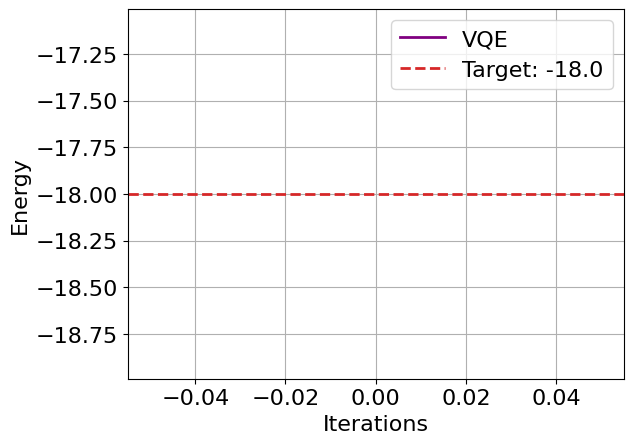

In [80]:
plt.plot(intermediate_info_real_backend, color='purple', lw=2, label='VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [ ]:
## 3-3 Performance Score
Compute the relative error between the expected ground state energy and the VQE result.

In [81]:
# Compute the relative error between the expected ground state energy and the measured
computed_gse = intermediate_info_real_backend[-1]

print(f'Expected ground state energy: {gs_energy:.8f}')
print(f'Computed ground state energy: {computed_gse:.8f}')
print(f'Relative error: {100 * rel_err(gs_energy, computed_gse):.8f} %')

Traceback (most recent call last):
  Cell In[81], line 2
    computed_gse = intermediate_info_real_backend[-1]
IndexError: list index out of range

Use %tb to get the full traceback.


# Considerations
Feeling stuck? Below are a list of questions and considerations to help spark new ideas for your VQE implementation.

**Ansatz.** Carefully consult research literature for the best approach of ansatz selection. How might errors affect your ansatz? How many parameters are needed to reach the ground state? What properties of the Hamiltonian could help simplify the ansatz?

**Classical optimizer.** What optimizer will pair well with for your choice of ansatz and measurement parameters? What noise do you expect from the quantum computer, and what noise sensitivity can the classical optimizer withstand? How many iterations will be needed?

**Initial state/point.** Is there an initial quantum state that really helps things get going? What about a starting point for the circuit parameters? Does the VQE give the same results for different initial parameter values?

**Number of measurements.** How does the number of shots affect the VQE's convergence to the ground state energy? The expectation value of the Hamiltonian is a sum of the expectation values of each of the 54 terms. What is the least number of circuit executions necessary to compute the expectation value of the Hamiltonian? What is the optimal number of circuit executions for stable convergence?

**Many qubits.** Working with larger numbers of qubits is its own challenge. For example, what's a concise way of writing down or even visualizing the 4096 digit ground state? What methods and techniques will not scale well? What techniques would scale well if this VQE were to be done on a larger system? How can you reduce your execution time of the real device?

**Error mitigation.** What errors are most prevalent, and how can you reduce them efficiently? What error mitigation techniques will scale well?

In [153]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

'0.9.1'

In [154]:
import qiskit.tools.jupyter
%qiskit_version_table